<a href="https://colab.research.google.com/github/Shopping-Yuan/ML2021HW/blob/Shopping_vscode_branch/HW12/HW12_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Setting



###Install Package



In [ ]:
!apt install python3-opengl
!apt install xvfb
!pip install pyvirtualdisplay
!pip install swig
!pip install gym[box2d]
!pip install tqdm
# !pip install box2d-kengz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-opengl is already the newest version (3.1.5+dfsg-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.8).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


###Set Seed

In [ ]:
import torch
import numpy as np
import random
seed = 543 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  # torch.use_deterministic_algorithms(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

###Pretrain

In [21]:
import torch.nn as nn
import torch.nn.functional as F
class Q_Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(12, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

In [19]:
def get_pretrain_data(env):
  PRETRAIN_EPISON = 100000
  for episode in range(PRETRAIN_EPISON):
      state = env.reset()
      seq_rewards = []
      seq_state = []
      seq_action = []
      while not done:

          seq_state.append(state)
          action = env.action_space.sample()
          action_one_hot = [0.,0.,0.,0.]
          action_one_hot[int[action]] += 1.
          seq_action.append(action_one_hot)
          next_state, reward, done, _ = env.step(action)

          seq_rewards.append(0)
          len_of_seq_reward = len(seq_rewards)
          seq_rewards = [seq_rewards[index] +(0.99)**(len_of_seq_reward-(index+1))\
                  *reward for index in range(len_of_seq_reward)]

          state = next_state
      seq_state_action = torch.tensor([seq_state[i]+seq_action[i] for i in range(len(seq_state))])
      seq_rewards = torch.tensor(seq_rewards)
      return seq_state_action,seq_rewards

In [20]:
from torch.utils.data import Dataset, DataLoader
class Pretrain_Dataset(Dataset):
  def __init__(self,data,label):
    self.data = data
    self.label = label
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    return self.data[index], self.label[index]
def prep_dataloader(dataset,batch_size):
  dataloader = DataLoader(
        dataset, batch_size,
        shuffle=True, drop_last=False,
        num_workers=0, pin_memory=False)
  return dataloader


「環境」給予的 reward 大致是這樣計算：
- 小艇墜毀得到 -100 分
- 小艇在黃旗幟之間成功著地則得 100~140 分
- 噴射主引擎（向下噴火）每次 -0.3 分
- 小艇最終完全靜止則再得 100 分
- 小艇每隻腳碰觸地面 +10 分
- 噴射左或右引擎（順時針或逆時針旋轉）每次 -0.03 分

###Training

In [ ]:
import random
from collections import deque
class Buffer():
  def __init__(self, capacity):
      self.memory = deque([], maxlen=capacity)
  def to_memory(self, new_data):
      self.memory.append(new_data)
  def __len__(self):
      return len(self.memory)
  def sample_batch(self, batch_size):
      return random.sample(self.memory, batch_size)
# test
# dq = deque([], 10)
# for i in range(20):
#     dq.append(i)
#     print(dq)

In [ ]:
# from collections import namedtuple
# Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))
# test
# transition = namedtuple('transition_class', ['up', 'down', 'left', 'right'])
# s = transition(1, 2, 'q', [1, 2, 3])
# s = transition("A","B","C","D")
# print(s.right)
# print(transition)
# import random
# random.sample(s, 2)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
import gym
import math
import torch.optim as optim
from torch.distributions import Categorical
from collections import namedtuple

class Q_Learning_Process():
    def __init__(self, env, device, policy_net, target_net, buffer):
        self.env = env
        self.device = device
        self.policy_net = policy_net.to(self.device)
        self.target_net = target_net.to(self.device)
        self.buffer = buffer
    def test_env(self):
      self.env.reset()
      env_as_nparray = self.env.render(mode='rgb_array')
      img = plt.imshow(env_as_nparray)
      done = False
      while not done:
          # action = self.env.action_space.sample()
          action = 3
          observation, reward, done, info = self.env.step(action)
          img.set_data(self.env.render(mode='rgb_array'))
          display.display(plt.gcf())
          display.clear_output(wait=True)
          print(reward)
          # test env
          # initial_state = self.env.reset()
          # random_action = self.env.action_space.sample()
          # observation, reward, done, info = self.env.step(random_action)
          # print(initial_state)
          # print(self.env.observation_space) # 8-dim of vectors
          # print(self.env.action_space) # Discrete(4): 4 kinds of actions
          # print(random_action)
          # print(done)
          # print(reward)
    def _exploration(self,steps_done,state,EPS_START,EPS_END,EPS_DECAY):
        sample = random.random()
        # eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        #     math.exp(-1. * steps_done / EPS_DECAY)
        eps_threshold = EPS_START + (EPS_END-EPS_START) * math.exp(-1.*steps_done / EPS_DECAY)
        steps_done += 1
        # if sample > eps_threshold:
        if sample < eps_threshold:
            with torch.no_grad():
              # t.max(1) will return the largest column value of each row.
              # second column on max result is index of where max element was
              # found, so we pick action with the larger expected reward.
              input = torch.FloatTensor(state).unsqueeze(0).to(self.device)
              return self.policy_net(input).max(1).indices.detach().item()
        else:
          # return torch.LongTensor([self.env.action_space.sample()]).to(self.device).detach().item()
          return self.env.action_space.sample()

    def update_buffer(self,EPISODE_PER_BATCH,EPS_START,EPS_END,EPS_DECAY):
        transition = namedtuple('transition_calss',('state', 'action', 'next_state', 'reward'))
        rewards = 0
        total_rewards = []
        final_rewards = []
        for e in range(EPISODE_PER_BATCH):
          # print(f"It is {e+1}th episode")
          done = False
          state = self.env.reset()
          steps_done = 0
          while not done:
            action = self._exploration(steps_done, state,EPS_START,EPS_END,EPS_DECAY)
            next_state, reward, done, info = self.env.step(action)
            rewards += reward
            if not done:
              data = transition(state,action,next_state,reward)
              self.buffer.to_memory(data)
            else:
              total_rewards.append(rewards)
              final_rewards.append(reward)
            state = next_state
            steps_done += 1
        return sum(total_rewards)/len(total_rewards),\
            sum(final_rewards)/len(total_rewards)

    def optimize_model(self, LR, BATCH_SIZE, GAMMA):
        self.policy_net.train()
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)
        # self.optimizer = optim.SGD(self.policy_net.parameters(), lr=LR)
        batch = self.buffer.sample_batch(BATCH_SIZE)
        state = torch.FloatTensor([d.state for d in batch]).to(self.device)
        action = torch.LongTensor([d.action for d in batch]).view(-1,1).to(self.device)
        next_state = torch.FloatTensor([d.next_state for d in batch]).to(self.device)
        reward = torch.LongTensor([d.reward for d in batch]).to(self.device)

        Q = self.policy_net(state).gather(1,action)
        # max_action = Q.max(1).indices.view(-1,1)
        # with torch.no_grad():
        #   Q_next = self.target_net(next_state).gather(1,max_action)
        for param in self.target_net.parameters():
          param.requires_grad = False

        Q_next = self.target_net(next_state).max(1).values
        loss = F.huber_loss(Q,reward + GAMMA*Q_next)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss

    def eval(self,EPISODE_PER_BATCH):
        rewards = 0
        total_rewards = []
        final_rewards = []
        for e in range(EPISODE_PER_BATCH):
          done = False
          state = self.env.reset()
          steps_done = 0
          while not done:
            input = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            action = \
            self.target_net(input).max(1).indices.detach().item()
            next_state, reward, done, info = self.env.step(action)
            rewards += reward
            if done:
              total_rewards.append(rewards)
              final_rewards.append(reward)
        return sum(total_rewards)/len(total_rewards),\
            sum(final_rewards)/len(total_rewards)

    def save(self, PATH): # You should not revise this
        Model_Dict = {
            "policy_net" : self.policy_net.state_dict(),
            "target_net" : self.target_net.state_dict(),
            "optimizer" : self.optimizer.state_dict(),
        }
        torch.save(Model_Dict, PATH)

    def load(self, PATH): # You should not revise this
        checkpoint = torch.load(PATH)
        self.policy_net.load_state_dict(checkpoint["policy_net"])
        self.target_net.load_state_dict(checkpoint["target_net"])
        #如果要儲存過程或是中斷訓練後想繼續可以用喔 ^_^
        self.optimizer.load_state_dict(checkpoint["optimizer"])

In [ ]:
# env = gym.make('LunarLander-v2')
# fix(env, seed) # fix the environment
# policy_net = Q_Network()
# target_net = Q_Network()
# buffer = Buffer(6000)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# agent = Q_Learning_Process(env,device,policy_net,target_net,buffer).test_env()
# agent

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def plot_rewards_when_training(is_ipython,train_total_rewards,train_final_rewards):
  plt.figure(1)
  plt.clf()
  plt.title('train_reward')
  index = list(range(len(train_total_rewards)))
  plt.plot(index, train_total_rewards, c='tab:cyan', label='total rewards')
  plt.plot(index, train_final_rewards, c='tab:red', label='final rewards')
  plt.xlabel('Batch')
  plt.ylabel('Reward')
  plt.legend()
  if is_ipython:
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [ ]:
from tqdm.notebook import tqdm
import csv
import time

def train_eval(is_ipython,
        env,
        device,
        LOAD,
        MODEL_PATH,
        REWARD_PATH,
        EVAL_PATH,
        SAVE_BATCH,
        BUFFER_SIZE,
        LR,
        NUM_BATCH,
        EPISODE_PER_BATCH,
        GAMMA,
        TAU,
        EPS_START,
        EPS_END,
        EPS_DECAY,
        BATCH_SIZE):
  start = time.time()

  buffer = Buffer(BUFFER_SIZE)
  agent = Q_Learning_Process(env,device,Q_Network(),Q_Network(),buffer)
  agent.target_net.load_state_dict(agent.policy_net.state_dict())

  agent.policy_net.train()
  agent.target_net.train()

  if LOAD :
    agent.load(MODEL_PATH)
    print(f"Load model from {MODEL_PATH}")

  loss = []
  train_total_rewards = []
  train_final_rewards = []
  with open(REWARD_PATH, 'w') as f:
      writer = csv.writer(f)
      writer.writerow(['total_reward', 'final_reward'])
  with open(EVAL_PATH, 'w') as f:
      writer = csv.writer(f)
      writer.writerow(['total_reward', 'final_reward'])

  prg_bar = tqdm(range(NUM_BATCH))
  for batch_index in prg_bar:
    # print(f"It is {batch_index+1}th batch")

    total_reward, final_reward = \
    agent.update_buffer(EPISODE_PER_BATCH,EPS_START,EPS_END,EPS_DECAY)
    train_total_rewards.append(total_reward)
    train_final_rewards.append(final_reward)

    now_loss = agent.optimize_model(LR,BATCH_SIZE,GAMMA).detach().item()
    loss.append(now_loss)
    # agent_target_net_state_dict = agent.target_net.state_dict()
    # agent_policy_net_state_dict = agent.policy_net.state_dict()
    # for key in agent_policy_net_state_dict:
    #     agent_target_net_state_dict[key] = \
    #     agent_policy_net_state_dict[key]*TAU + agent_target_net_state_dict[key]*(1-TAU)
    # agent.target_net.load_state_dict(agent_target_net_state_dict)

    if (batch_index+1) % SAVE_BATCH ==0:
      agent.target_net.load_state_dict(agent.policy_net.state_dict())
      rewards_to_write = \
       list(zip(train_total_rewards[(batch_index+1)-SAVE_BATCH:], \
           train_final_rewards[(batch_index+1)-SAVE_BATCH:], \
           loss[(batch_index+1)-SAVE_BATCH:]))
      agent.save(MODEL_PATH)
      with open(REWARD_PATH, 'a') as f:
        writer = csv.writer(f)
        for t,f,l in rewards_to_write:
          writer.writerow([t, f, l])

      eval_total_reward, eval_final_reward = agent.eval(EPISODE_PER_BATCH)
      with open(EVAL_PATH, 'a') as f:
        writer = csv.writer(f)
        writer.writerow([eval_total_reward, eval_final_reward])
      print(f"Save model from {batch_index+1}th batch to {MODEL_PATH}")
      print(f"Save policy rewards from {(batch_index+2)-SAVE_BATCH}th"+ f"to {batch_index+1}th batchs to {REWARD_PATH}")
      print(f"Save target rewards of {batch_index+1}th batch to {REWARD_PATH}")
      plot_rewards_when_training(is_ipython,train_total_rewards,train_final_rewards)

  end = time.time()
  print(f"total_spend_time = {end-start} seconds")

In [ ]:
def plot_rewards(REWARD_PATH,EVAL_PATH,**kwargs):
  avg_total_rewards = []
  avg_final_rewards = []
  loss = []
  with open(REWARD_PATH, 'r') as f:
    reward_reader = csv.reader(f)
    header = next(reward_reader)
    for t,f,l in reward_reader:
      avg_total_rewards.append(float(t))
      avg_final_rewards.append(float(f))
      loss.append(float(l))
  index = list(range(len(loss)))
  plt.plot(index,loss)
  plt.title("Loss")
  plt.show()

  plt.plot(index,avg_total_rewards)
  plt.title("Policy Total Rewards")
  # plt.ylim(-5., 5.)
  plt.show()
  plt.plot(index,avg_final_rewards)
  plt.title("Policy Final Rewards")
  plt.show()

  eval_final_rewards = []
  eval_total_rewards = []
  with open(EVAL_PATH, 'r') as f:
    reward_reader = csv.reader(f)
    header = next(reward_reader)
    for t,f in reward_reader:
      eval_total_rewards.append(float(t))
      eval_final_rewards.append(float(f))
  index = list(range(len(eval_total_rewards)))
  plt.plot(index,eval_total_rewards)
  plt.title("Target Total Rewards")
  # plt.ylim(-5., 5.)
  plt.show()
  plt.plot(index,eval_final_rewards)
  plt.title("Target Final Rewards")
  plt.show()

In [ ]:
def inference(env,device,BUFFER_SIZE,LR,**kwargs):
  policy_net = Q_Network()
  target_net = Q_Network()
  target_net.load_state_dict(policy_net.state_dict())
  buffer = Buffer(BUFFER_SIZE)
  optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

  agent = Q_Learning_Process(env,device,policy_net,target_net,buffer,optimizer)
  agent.policy_net.eval()
  agent.target_net.eval()
  NUM_OF_TEST = 1
  test_total_reward = []
  action_list = []

  total_rewards = []
  final_rewards = []
  for e in range(EPISODE_PER_BATCH):
    done = False
    state = self.env.reset()
    steps_done = 0
    while not done:
      action = \
      target_net(torch.FloatTensor(state).unsqueeze(0)).max(1).indices.detach().item()
      next_state, reward, done, info = env.step(action)
      total_rewards.append(reward)


  for i in range(NUM_OF_TEST):
    actions = []
    state = env.reset()

    img = plt.imshow(env.render(mode='rgb_array'))

    total_reward = 0

    done = False
    while not done:
        action, _ = agent.sample(state)
        actions.append(action)
        state, reward, done, _ = env.step(action)

        total_reward += reward

        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
    print(total_reward)
    test_total_reward.append(total_reward)

    action_list.append(actions) #儲存你測試的結果
    print("length of actions is ", len(actions))
    print(f"Your final reward is : %.2f"%np.mean(test_total_reward))
    print("Action list looks like ", action_list)
    # set the max number of 0
    max_len = max([len(x) for x in action_list])
    temp = [x+ [-1]*max_len for x in action_list]
    action_list_pad = [x[0:max_len] for x in temp]
    print("Action list's shape looks like ", np.shape(action_list_pad))
    distribution = {}
    for actions in action_list:
      for action in actions:
        if action not in distribution.keys():
          distribution[action] = 1
        else:
          distribution[action] += 1
    print(distribution)
    PATH = "Action_List_test.npy" # 可以改成你想取的名字或路徑
    np.save(PATH ,np.array(action_list_pad))
    from google.colab import files
    files.download(PATH)
    action_list_pad = np.load(PATH,allow_pickle=True) #到時候你上傳的檔案
    action_list = [[x[i] for i in range(len(x)) if x[i]>=0] for x in action_list_pad]
    seed = 543 #到時候測試的seed 請不要更改
    fix(env, seed)

    agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式

    test_total_reward = []
    for actions in action_list:
      state = env.reset()
      img = plt.imshow(env.render(mode='rgb_array'))

      total_reward = 0

      done = False
      # while not done:
      done_count = 0
      for action in actions:
          # action, _ = agent1.sample(state)
          state, reward, done, _ = env.step(action)
          done_count += 1
          total_reward += reward
          if done:

            break
          img.set_data(env.render(mode='rgb_array'))
          display.display(plt.gcf())
          display.clear_output(wait=True)
      print(f"Your reward is : %.2f"%total_reward)
      test_total_reward.append(total_reward)
    print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

In [ ]:
save_load ={
"LOAD" : False,
"MODEL_PATH" : "/content/DQN_model.pth",
"REWARD_PATH" : "/content/DQN_rewards.csv",
"EVAL_PATH" : "/content/DQN_eval_rewards.csv",
"SAVE_BATCH" : 10
}
h_paras = {
"BUFFER_SIZE" : 100000,
"BATCH_SIZE" : 512,#128
"EPISODE_PER_BATCH" : 10,#5
"NUM_BATCH" : 6000,
"GAMMA" : 0.99,
"EPS_START" : 0.05,#0.9
"EPS_END" : 1,#0.05
"EPS_DECAY" : 2000,#2000
"TAU" : 0.005,#0.005
"LR" : 1e-4,
}

total_spend_time = 2670.484459400177 seconds


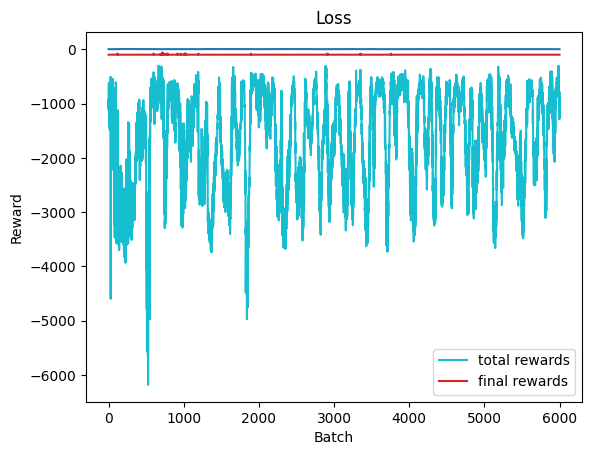

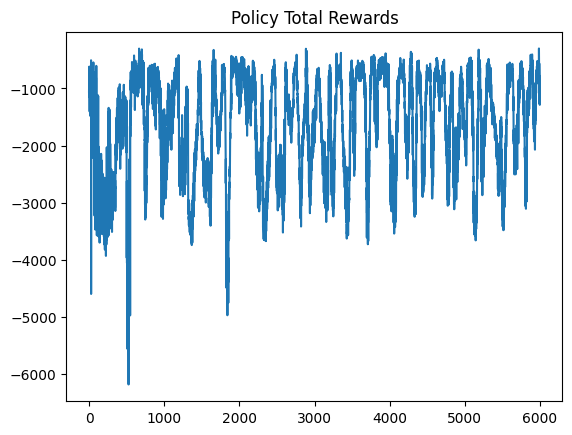

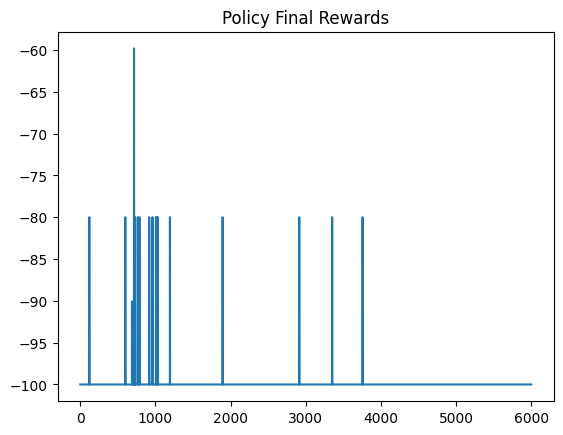

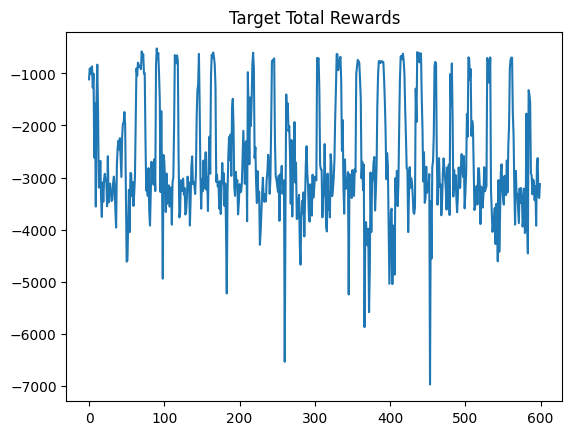

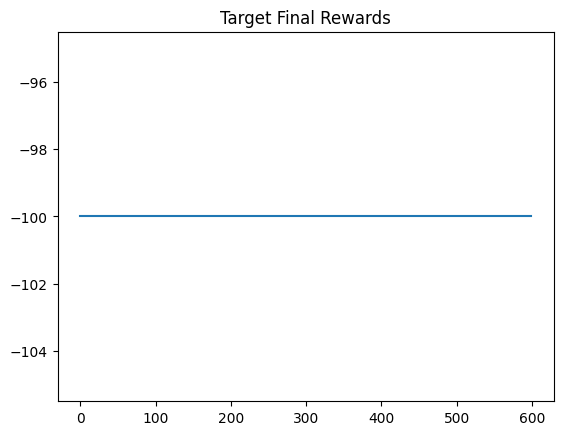

In [ ]:
# %%capture
%matplotlib inline
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
def main():
  env = gym.make('LunarLander-v2')
  fix(env, seed) # fix the environment
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  train_eval(is_ipython,env,device,**save_load,**h_paras)
  plot_rewards(**save_load)
  # inference(env,device,**save_load,**h_paras)
main()

In [ ]:
import matplotlib
matplotlib.get_backend()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'module://matplotlib_inline.backend_inline'